# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2024-2025

In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import scipy
from scipy.stats import beta
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import seaborn as sns

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

### Exercise 1: Simulation of circadian gene regulation

In this exercise, we revisit and extend the concepts from Week 9, focusing on the transcription and splicing of a pre-mRNA to produce mRNA. We describe this process using a two-dimensional Ordinary Differential Equation (ODE), similar to our previous approach but with a key difference: we now incorporate **time-dependent** transcription and degradation rates to model circadian rhythms.

The system is defined by the following ODEs:

\begin{array}{ll}
\frac{dP}{dt} = s(t) - \rho P \\  
\\
\frac{dM}{dt} = \rho P - k(t) M \\
\end{array}

where  $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is defined by $\omega=\frac{2\pi}{T}$ with $T=24h$.  

$s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that the peak of $s(t)$ is at $t=0$.  
 
Similarly, we will consider the degradation rate $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ represents the constant splicing rate of pre-mRNA $P$ into mRNA $M$.

### Question 1
1. Adapt the code from Week 9 exercises to simulate this system with rhythmic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  

2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    * How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 
    
    Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).  

3. Now introduce rhythmic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a rhyhtmic mRNA accumulation when the synthesis is constant ($\epsilon_s=0$). 
    


### Answer 1

1. Adaptation of code into function `circadian_ode()`, `circadian_simualation`, `plot_circadian` and `interactive_circadian()`.

In [11]:
def circadian_ode(y, time, s0, epsilon_s, k0, epsilon_k, rho, omega, t_k):
    """
    ODEs for circadian rhythms in transcription and degradation rates.

    P: pre-mRNA concentration
    M: mRNA concentration
    s0: baseline transcription rate
    epsilon_s: relative amplitude of rhythmic transcription
    k0: baseline degradation rate
    epsilon_k: relative amplitude of rhythmic degradation
    rho: splicing rate
    omega: angular frequency (2π/T, with T=24h)
    t_k: phase shift for degradation
    """
    P, M = y
    
    # Time-dependent transcription and degradation rates
    s_t = s0 * (1 + epsilon_s * np.cos(omega * time))
    k_t = k0 * (1 + epsilon_k * np.cos(omega * (time - t_k)))
    
    # ODEs
    dPdt = s_t - rho * P
    dMdt = rho * P - k_t * M
    return [dPdt, dMdt]


def circadian_simulation(parameters, initial_conditions, time):
    """
    Simulate the circadian ODE system with given parameters.
    parameters: dict containing s0, epsilon_s, k0, epsilon_k, rho, omega, t_k
    initial_conditions: [P0, M0]
    time: time array for simulation
    """
    s0 = parameters['s0']
    epsilon_s = parameters['epsilon_s']
    k0 = parameters['k0']
    epsilon_k = parameters['epsilon_k']
    rho = parameters['rho']
    omega = parameters['omega']
    t_k = parameters['t_k']
    
    results = odeint(circadian_ode, initial_conditions, time, args=(s0, epsilon_s, k0, epsilon_k, rho, omega, t_k))
    return results

def plot_circadian(parameters, initial_conditions, time):
    """
    Plot results of circadian ODE simulation.
    """
    results = circadian_simulation(parameters, initial_conditions, time)
    P, M = results[:, 0], results[:, 1]
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(time, P, label="Pre-mRNA (P)", linewidth=2)
    plt.plot(time, M, label="mRNA (M)", linewidth=2)
    
    # Optional: add time-dependent rates for visualization
    s_t = parameters['s0'] * (1 + parameters['epsilon_s'] * np.cos(parameters['omega'] * time))
    k_t = parameters['k0'] * (1 + parameters['epsilon_k'] * np.cos(parameters['omega'] * (time - parameters['t_k'])))
    
    plt.plot(time, s_t, label="Transcription rate (s(t))", linestyle="--", color="blue", alpha=0.7)
    plt.plot(time, k_t, label="Degradation rate (k(t))", linestyle="--", color="red", alpha=0.7)
    
    plt.xlabel("Time (h)")
    plt.ylabel("Concentration / Rate")
    plt.title("Circadian Dynamics of Pre-mRNA and mRNA")
    plt.legend()
    plt.show()

def interactive_circadian(s0=5, epsilon_s=0.5, k0=0.05, epsilon_k=0.5, rho=0.4, omega=2*np.pi/24, t_k=12, P0=0, M0=0):
    """
    Interactive widget to explore circadian dynamics.
    """
    parameters = {
        's0': s0,
        'epsilon_s': epsilon_s,
        'k0': k0,
        'epsilon_k': epsilon_k,
        'rho': rho,
        'omega': omega,
        't_k': t_k
    }
    initial_conditions = [P0, M0]
    time = np.linspace(0, 200, 1000)  # Simulate over 48 hours
    plot_circadian(parameters, initial_conditions, time)

2. Setting of  $\epsilon_k$=0 and vary $k_0$ and $\epsilon_s$:

In [12]:
# Interactive exploration
interact(interactive_circadian, s0=(1, 10, 0.5), epsilon_s=(0, 1, 0.1), k0=(0.01, 1.5, 0.1), epsilon_k=(0), rho=(0.1, 1, 0.1), t_k=(0, 24, 1))

interactive(children=(FloatSlider(value=5.0, description='s0', max=10.0, min=1.0, step=0.5), FloatSlider(value…

<function __main__.interactive_circadian(s0=5, epsilon_s=0.5, k0=0.05, epsilon_k=0.5, rho=0.4, omega=0.2617993877991494, t_k=12, P0=0, M0=0)>

**Overall conclusions**

First of all, as $\epsilon_k$ is set to zero, the oscillatory term of the mRNA degradation rate $k(t)$ is eliminated, which delivers its lineal behavious visible in the plot. Moreover, by changing the $k_{0}$ value (which would account for the maximum amplitude of oscillation of the degradation term in normal behaviour) sets the constant $k(t)$ value. Higher $k_{0}$ means more degradation therefore maximum mRNA values are reduced. Keep in mind that the oscillatory behaviour of mRNA comes from the oscillatory one of the pre-mRNA, as degradation is linear in this setting as explained earlier.

Modifying the term $\epsilon_s$ accounts for the oscillatory behaviour of the splicing rate $s(t)$. Bigger values produce higher peaks and more accentuated oscillations of cosines term increases its importance into the splicing rate. 

* How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?

Delay between the two _waves_ is set by term $t_k$, which in this case it is unchanged by only modifying $k_0$. The $k_0$ only accentuates oscillations and increases peaks.  

* How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$?

The minimum value of $M(t)$ at the given setting (initial conditions $P_0$ and $M_0$ both null) is zero thus the ratio can not be computed directly. But as we are asked to use a wide range of $k_o$ parameter values, an oscillatory behaviour of $M(t)$ can be seen later on. By taking only that oscillatory part:



In [13]:
parameters = {
        's0': 5.0,
        'epsilon_s': 0.5,
        'k0': np.linspace(0.1, 2.5, 10),
        'epsilon_k': 0,
        'rho': 0.4,
        'omega': 2*np.pi/24,
        't_k': 12
    }
initial_conditions = [0, 0]
time = np.linspace(0, 48, 1000)

ratios = []
k0_values = parameters['k0']

for k0 in k0_values:
    parameters['k0'] = k0  # Update the degradation rate
    M = circadian_simulation(parameters, initial_conditions, time)[:, 1]  # Extract mRNA (M) values
    # Focus on time from hour 10
    M_from_10h = M[time >= 10]
    max_M = np.max(M_from_10h)
    min_M = np.min(M_from_10h)
    ratio = max_M / min_M if min_M != 0 else np.nan  # Avoid division by zero
    ratios.append((k0, ratio))
    print(f"Ratio for k = {k0:.3f} is {ratio:.3f}")

Ratio for k = 0.100 is 1.848
Ratio for k = 0.367 is 2.088
Ratio for k = 0.633 is 2.286
Ratio for k = 0.900 is 2.364
Ratio for k = 1.167 is 2.400
Ratio for k = 1.433 is 2.419
Ratio for k = 1.700 is 2.430
Ratio for k = 1.967 is 2.437
Ratio for k = 2.233 is 2.442
Ratio for k = 2.500 is 2.445


We can see that once it enters the oscillatory behaviour (which happens faster and more accentuated at higher values of $k_0$), the ratio stabilizes at $\approx$ 2.4.

### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver and muscle

In this exercise, we will analyze RNA-seq data from mouse liver and muscle under a night-restricted feeding regimen and in the presence of a 12-hour light-dark cycle. The samples were harvested every 2 hours around the clock, with higher resolution around the fasting-feeding transition (ZT12), in two replicates. Similar to the Week 9 exercises on RNA-seq data, gene expression was quantified at the intron (i.e., unspliced) and exon (i.e., spliced) levels. Note that the data are $log_2$-transformed and normalized by transcript length (RPKM, Reads Per Kilobase per Million mapped reads).

### Function definition

In [14]:
def run_PCA(data, n_components=5, color_by='replicate', symbol_by='time', scale_data=True):
    
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """

    data_tmp = data.copy()
    
    # Scale and/or log-transform the data if specified
    if scale_data:
        data = scale(data)
    else:
        data = data

        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)

    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    if color_by=='time':
        pca_df[color_by] = pd.to_numeric(data_tmp.columns.get_level_values(color_by))
        palette='twilight'
    else:
        pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
        palette='Set1'
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette=palette)

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        axes[i].set_box_aspect(1) 
        # remove legend if it's not the first plot
        if i == 0:
        # Move legend outside for the first plot
            axes[i].legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, title=color_by)
        else:
        # Remove legend for all other plots
            axes[i].get_legend().remove()
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)
    plt.tight_layout()
    
    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca

def subselect(data, feature = None, replicate = None, time = None, condition = None):

    """
    Subselects samples from the full dataset based on the specified features, conditions, 
    replicates, and time points.

    Parameters:
    data: The full gene expression dataset.
    feature: The features to filter by (e.g., ['intron', 'exon']).
    replicate: The replicates to include.
    time: The time points to include.
    condition: The conditions to include (e.g, ['muscle', 'liver']).

    Returns:
    pd.DataFrame: The filtered dataset.
    """
    
    # Create boolean masks for each filtering criterion
    if feature is None:
        feature = data.columns.get_level_values('feature').unique()
    if replicate is None:
        replicate = data.columns.get_level_values('replicate').unique()
    if time is None:
        time = data.columns.get_level_values('time').unique()
    if condition is None:
        condition = data.columns.get_level_values('condition').unique()

    feature_mask  = data.columns.get_level_values('feature').isin(feature)
    condition_mask  = data.columns.get_level_values('condition').isin(condition)
    replicate_mask  = data.columns.get_level_values('replicate').isin(replicate)
    time_mask = data.columns.get_level_values('time').isin(time)

    # Use the masks to filter the data
    filtered_data = data.iloc[:, feature_mask & condition_mask & replicate_mask & time_mask]
    
    return filtered_data

def harm_reg(x, t, period):
    """
    Fit a harmonic regression model to a time series. Perform likelihood ratio test between the full and null model. Get p-value from the test.
    
    Parameters:
    x (array): Time series data
    t (array): Time points
    period (float): Period of the harmonic function (e.g., 24 for daily rhythms)

    Returns:
    tuple: Mean (mu), peak-to-through amplitude (amp), phase (phase), and p-value (p_val)

    """

    n = len(x)
    
    # Fit the null model (intercept only)
    X0 = np.ones((n, 1))  # Design matrix for the null model
    fit0 = sm.OLS(x, X0).fit()
    
    c = np.cos(2 * np.pi * t / period)
    s = np.sin(2 * np.pi * t / period)
    
    # Design matrix for the full model
    X1 = np.column_stack((np.ones(n), c, s))
    fit1 = sm.OLS(x, X1).fit()
    
    # Coefficients
    mu = fit1.params[0]
    a = fit1.params[1]
    b = fit1.params[2]
    
    # Likelihood ratio test
    lr_stat = 2 * (fit1.llf - fit0.llf)
    p_val = scipy.stats.chi2.sf(lr_stat, 2)
    
    # Amplitude and phase
    amp = 2 * np.sqrt(a**2 + b**2)
    phase = np.arctan2(b, a) % (2 * np.pi)
    phase = period * phase / (2 * np.pi)

    
    return mu, amp, phase, p_val

def fit_harmo(data, time, period):
    """
    Applies the harm_reg function to all genes for a given normalized gene expression dataset.

    Parameters:
    data (pd.DataFrame): Normalized gene expression dataset with genes as rows.
    time (array): Time points for the dataset.
    period (float): Period of the harmonic function (e.g., 24 for daily rhythms).

    Returns:
    pd.DataFrame: A DataFrame containing the amplitude, phase, p-value, qvalue and mu for each gene.
    """
    results = data.apply(lambda x: harm_reg(x.values, time, period), axis=1)
    results_df = pd.DataFrame(results.tolist(), index=data.index, columns=['mu', 'amp', 'phase', 'p_val'])
    results_df['p_val'] = results_df['p_val'].fillna(1)
    results_df['q_val'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

    return results_df


# Plotting function for side-by-side liver and muscle plots
def plot_gene_expression(dat_melted, gene_name):
    """
    Plots the expression of a gene in liver and muscle over time.

    Parameters:
    dat_melted (pd.DataFrame): The melted gene expression dataset.
    gene_name (str): The gene to plot.

    Returns:
    None
    """

    # Filter the melted DataFrame for the gene of interest
    data = dat_melted[dat_melted['gene.symb'] == gene_name]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # Create 1 row, 2 columns
    
    # Plot Liver
    sns.scatterplot(
        data=data[data['condition'] == 'liver'],  # Filter directly for liver
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[0]
    )
    sns.lineplot(
        data=data[data['condition'] == 'liver'],  # Filter directly for liver
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[0]
    )
    axes[0].set_title(f"{gene_name} Expression in Liver")
    axes[0].set_xlabel("Time (hours)")
    axes[0].set_ylabel("Expression Level")
    axes[0].grid(alpha=0.3)
    axes[0].set_box_aspect(1)  # Ensure square aspect ratio

    # Plot Muscle
    sns.scatterplot(
        data=data[data['condition'] == 'muscle'],  
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full', ax=axes[1]
    )
    sns.lineplot(
        data=data[data['condition'] == 'muscle'],  
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False, ax=axes[1]
    )
    axes[1].set_title(f"{gene_name} Expression in Muscle")
    axes[1].set_xlabel("Time (hours)")
    axes[1].grid(alpha=0.3)
    axes[1].set_box_aspect(1)  # Ensure square aspect ratio
    
    plt.show()

### Question 1

1. Perform PCA using the following 15 genes (core clock genes and selected clock output genes):  
 ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp', 'Ciart']``.  
Start by analyzing only the exons, then focus on the introns, for liver and muscle tissues separately.

2. Use the *fit_harmo* (i.e. harmonic regression) function on the data to assess and characterize genome-wide gene expression rhythmicity. Perform this analysis separately for the exons and introns, as well as for the muscle and liver tissues.

- Select rhythmic genes based on q-value thresholds (e.g., $q < 0.05$) and amplitude thresholds (e.g., $log_2$ peak-to-trough > 0.5) for further analysis.
- Provide histograms of the peak times (i.e. phase) and amplitudes ($log_2$ peak-to-trough) for the selected genes.
- Examine whether you observe patterns typically referred to as the 'morning' and 'evening' waves of gene expression.
- Compare your observations between liver and muscle tissues.



#### Load the RNA-seq data

In [15]:
dat = pd.read_csv("./log2_RPKM_Liver_Muscle_Intron_Exon.tsv",sep='\t')
dat.index = dat['gene.symb']
dat = dat.drop(['gene.symb'], axis=1)
dat.columns = dat.columns.str.replace('ZT','') # remove ZT from time
dat.columns = dat.columns.str.split('_', expand = True) # split columns by '_'
dat.columns.names = ['feature','condition','time','replicate'] # name the columns, multi-index

# Calculate the mean expression in liver and muscle
mean_liver = dat.xs('liver', level='condition', axis=1).mean(axis=1)
mean_muscle = dat.xs('muscle', level='condition', axis=1).mean(axis=1)

# Filter out lowly expressed genes
dat = dat[(mean_liver >= -4) & (mean_muscle >= -4)]

#melting the data for plotting later
dat_melted = dat.stack(level=[0, 1, 2, 3], future_stack=True).reset_index()
dat_melted.columns = ['gene.symb', 'feature', 'condition', 'time', 'replicate', 'expression']
dat_melted['time'] = dat_melted['time'].str.extract(r'(\d+)').astype(int)


# Subset the data for liver and muscle, intron and exon
dat_intron_liver = subselect(dat, feature = ['Intron'], condition = ['liver'])
dat_exon_liver = subselect(dat, feature = ['Exon'], condition = ['liver'])
dat_intron_muscle = subselect(dat, feature = ['Intron'], condition = ['muscle'])
dat_exon_muscle = subselect(dat, feature = ['Exon'], condition = ['muscle'])


#### Perform the PCA on clock related genes

In [16]:
circa_genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp','Ciart']

Exons analysis:

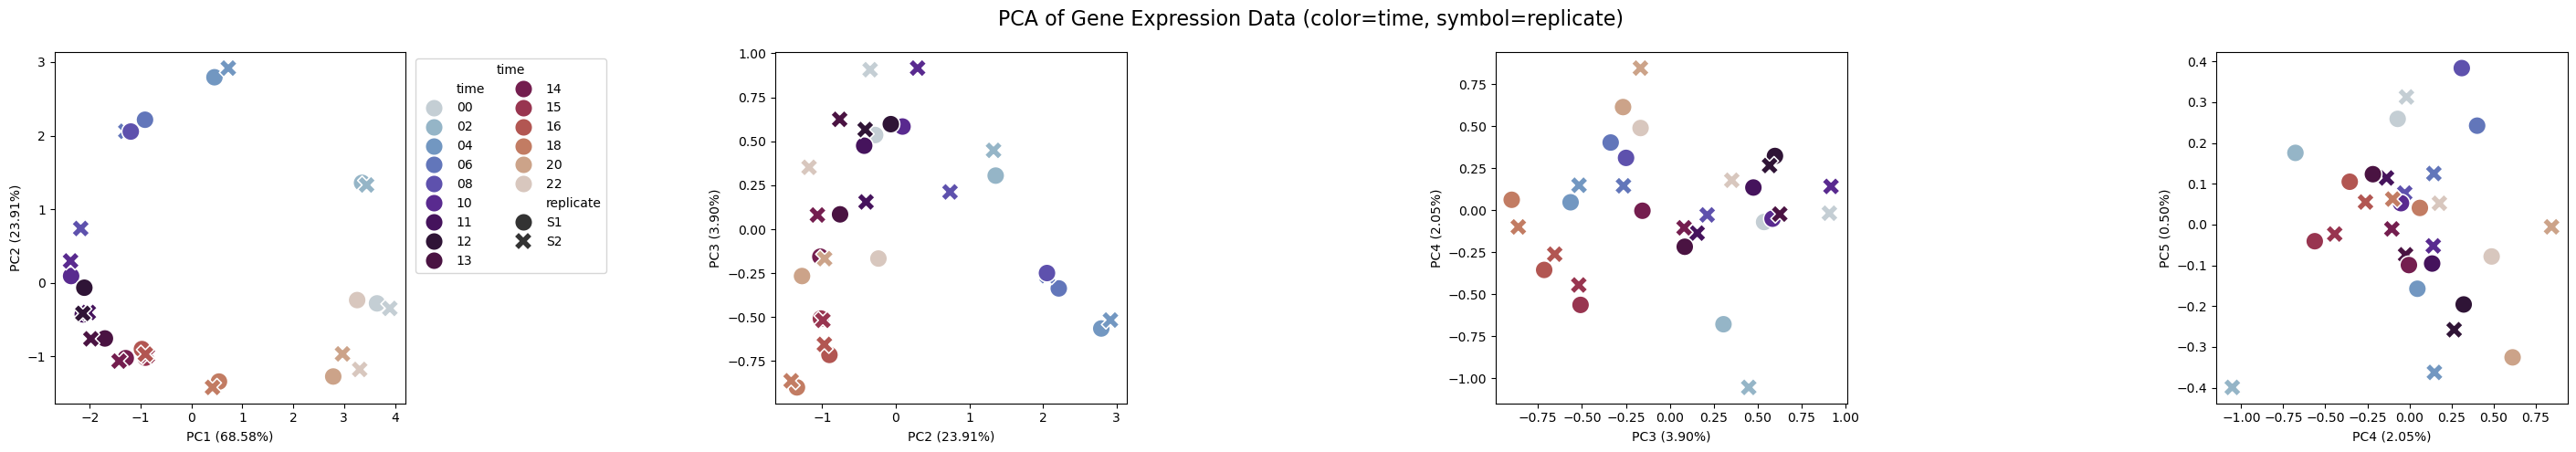

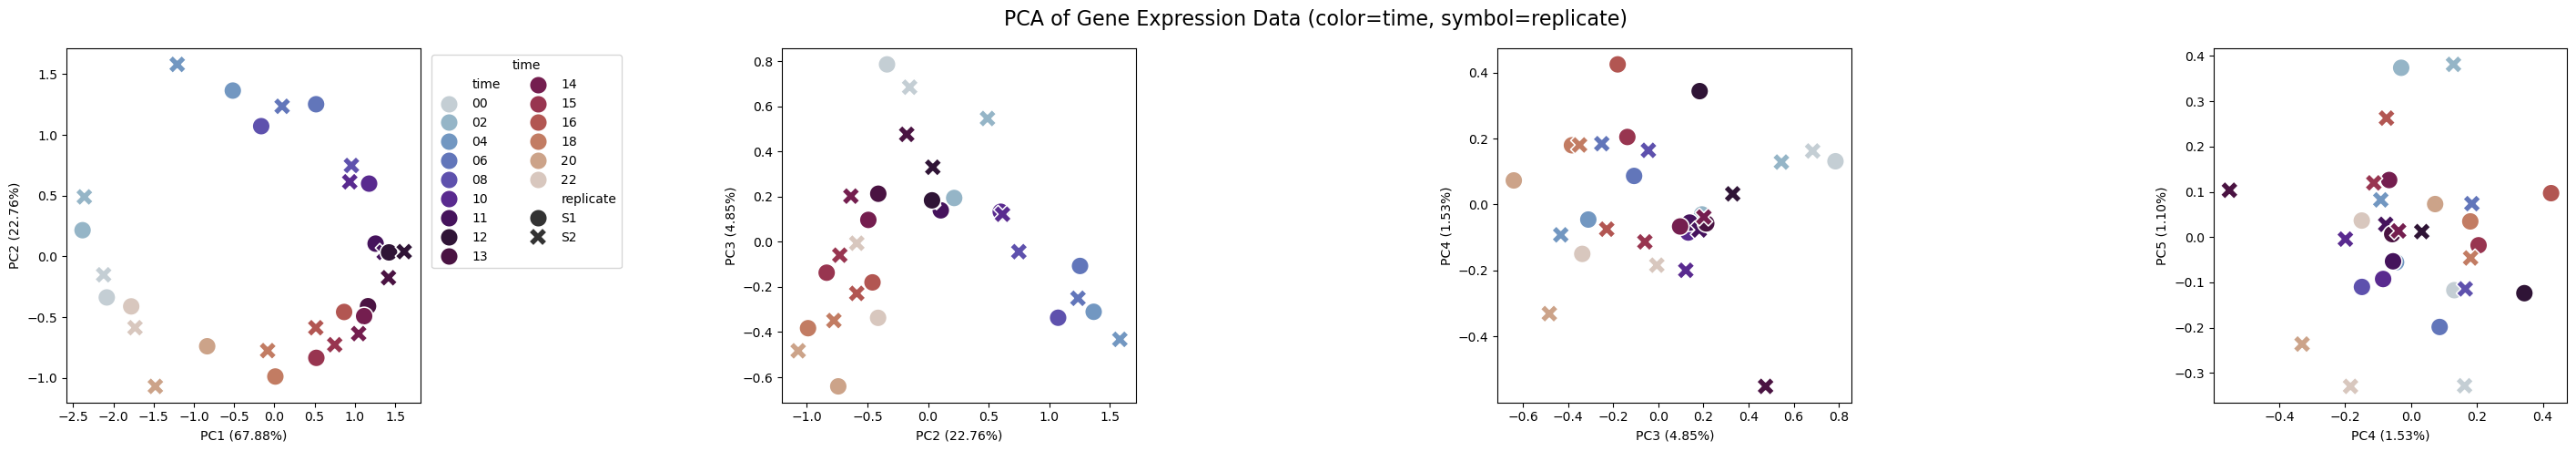

In [17]:
pca_results_exon_liver = run_PCA(dat_exon_liver.loc[dat_exon_liver.index.intersection(circa_genes)], n_components=5, color_by='time', symbol_by='replicate', scale_data=True)
pca_results_exon_muscle = run_PCA(dat_exon_muscle.loc[dat_exon_muscle.index.intersection(circa_genes)], n_components=5, color_by='time', symbol_by='replicate', scale_data=True)

PCA is able to show variance in data along its first two Principal Components, later on it looses this ability. It can be seen how there is a clock-wise grouping of data, which is consistent along the two replicates following the progression of the time-series data.

Introns analysis:

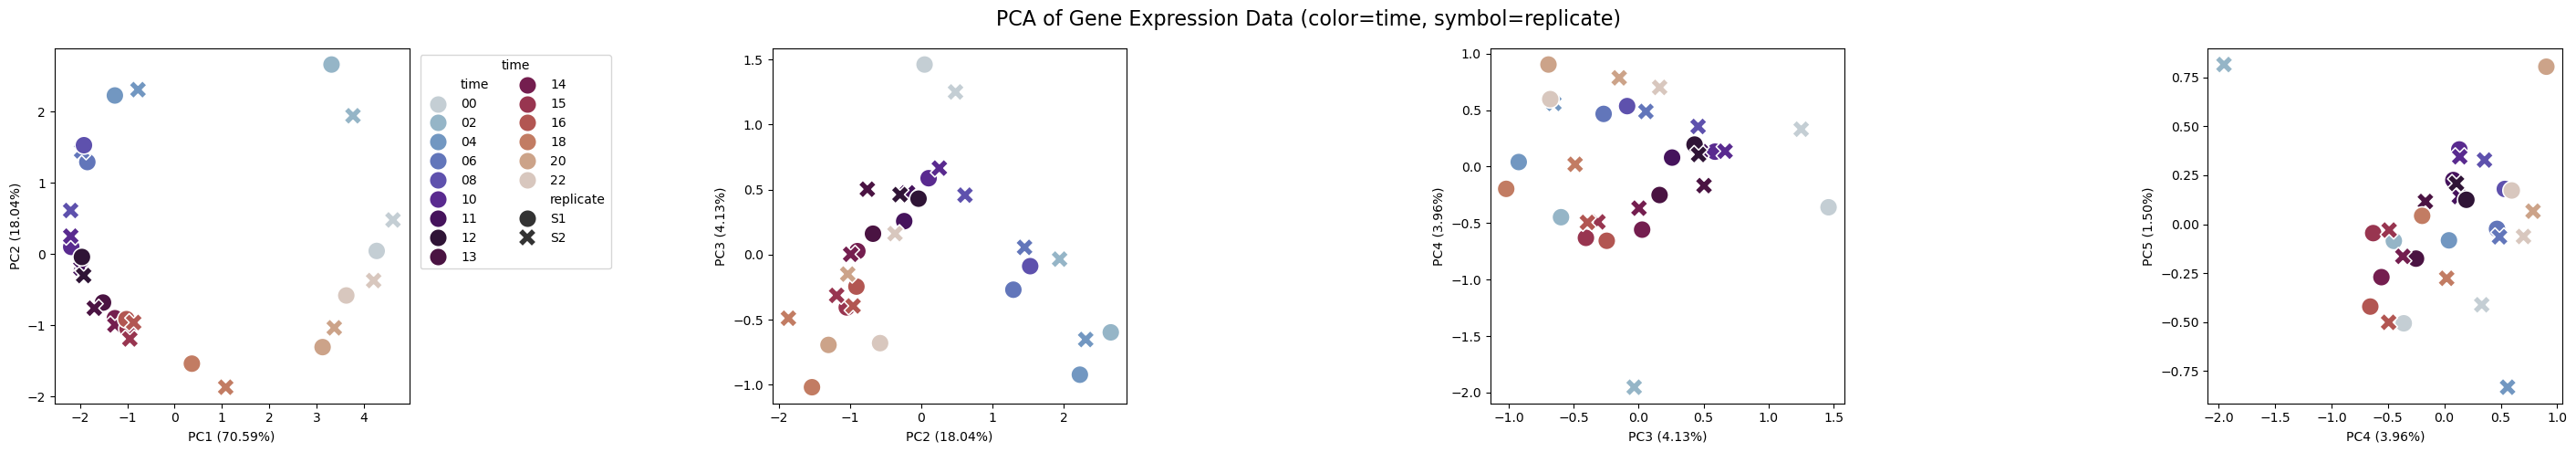

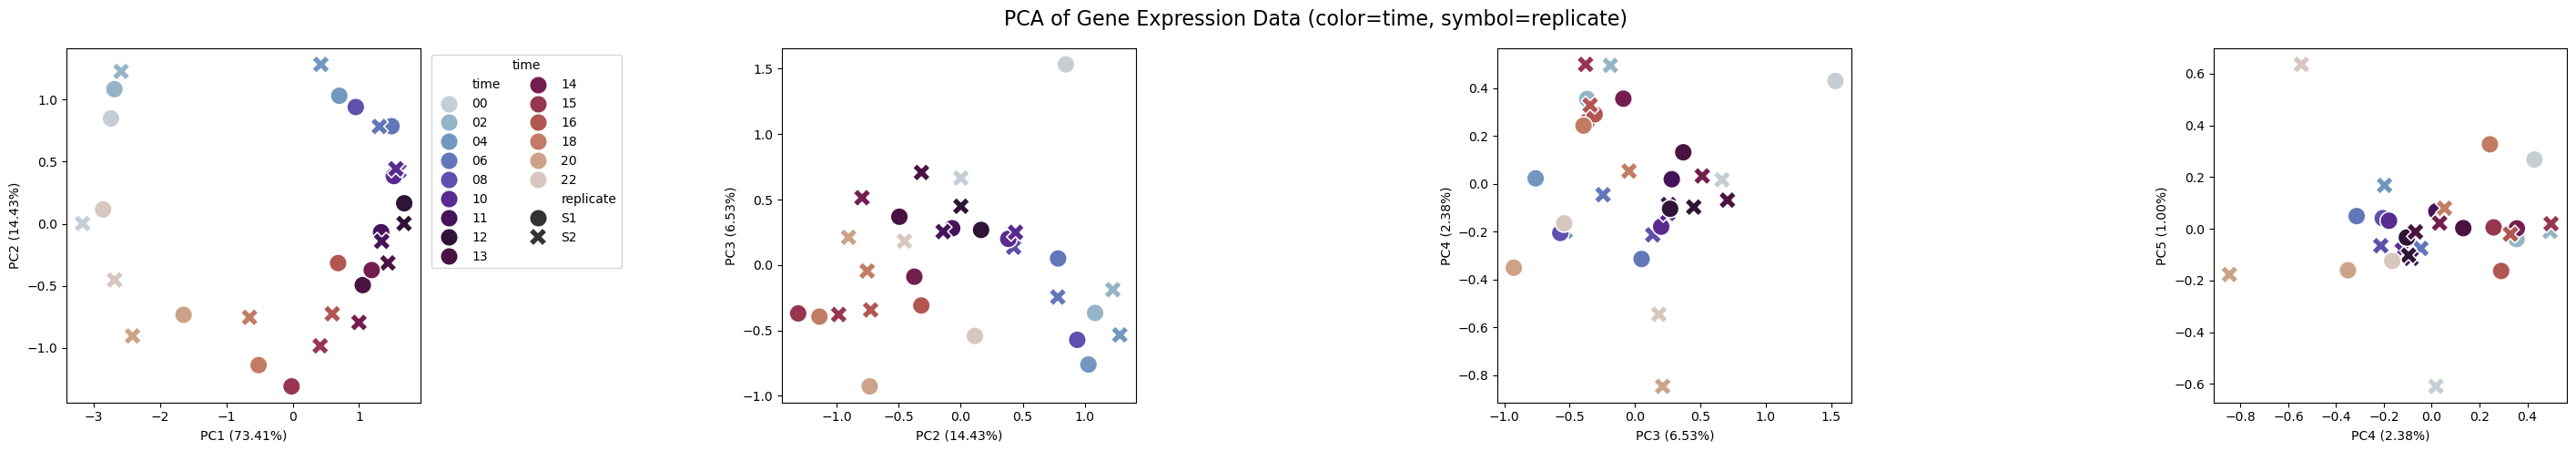

In [18]:
pca_results_intron_liver = run_PCA(dat_intron_liver.loc[dat_intron_liver.index.intersection(circa_genes)], n_components=5, color_by='time', symbol_by='replicate', scale_data=True)
pca_results_intron_liver = run_PCA(dat_intron_muscle.loc[dat_intron_muscle.index.intersection(circa_genes)], n_components=5, color_by='time', symbol_by='replicate', scale_data=True)

Intronic data shows the same behaviour as intronic. This clock-wise grouping following the time evolution highlighst the oscillatory behaviour of the clock genes selected, and how their expression at both pre-RNA and RNA changes in a fixed way along time. 

#### Assess gene expression rhythmicity genome-wide

In [19]:
# Apply the function to both intron and exon data for both tissues
T = 24
time = dat_exon_liver.columns.get_level_values('time').str.replace('ZT','').astype(int)

results_intron_liver = fit_harmo(dat_intron_liver, time, T)
results_exon_liver = fit_harmo(dat_exon_liver, time, T)
results_intron_muscle = fit_harmo(dat_intron_muscle, time, T)
results_exon_muscle = fit_harmo(dat_exon_muscle, time, T)

#### Define the genes of interest

In [20]:
q_val_threshold = 0.05
log2_amp_threshold = 0.5

# Define the genes with significant gene expression rhythm in the liver

gene_liver_i = np.logical_and(
    results_intron_liver['q_val'] < q_val_threshold,
    np.log2(results_intron_liver['amp']) > log2_amp_threshold
)

gene_liver_e = np.logical_and(
    results_exon_liver['q_val'] < q_val_threshold,
    np.log2(results_exon_liver['amp']) > log2_amp_threshold
)

rhythmic_genes_liver_i = results_intron_liver[gene_liver_i]
rhythmic_genes_liver_e = results_exon_liver[gene_liver_e]

# Define the genes with significant gene expression rhythm in the muscle

gene_muscle_i = np.logical_and(
    results_intron_muscle['q_val'] < q_val_threshold,
    np.log2(results_intron_muscle['amp']) > log2_amp_threshold
)

gene_muscle_e = np.logical_and(
    results_exon_muscle['q_val'] < q_val_threshold,
    np.log2(results_exon_muscle['amp']) > log2_amp_threshold
)

rhythmic_genes_muscle_i = results_intron_muscle[gene_muscle_i]
rhythmic_genes_muscle_e = results_exon_muscle[gene_muscle_e]

print(f"Significant rhythmic genes in liver (introns): {rhythmic_genes_liver_i.shape[0]}")
print(f"Significant rhythmic genes in liver (exons): {rhythmic_genes_liver_e.shape[0]}")
print(f"Significant rhythmic genes in muscle (introns): {rhythmic_genes_muscle_i.shape[0]}")
print(f"Significant rhythmic genes in muscle (exons): {rhythmic_genes_muscle_e.shape[0]}")

Significant rhythmic genes in liver (introns): 365
Significant rhythmic genes in liver (exons): 263
Significant rhythmic genes in muscle (introns): 118
Significant rhythmic genes in muscle (exons): 65


#### Plot phase and amplitude distribution for the rhythmic genes

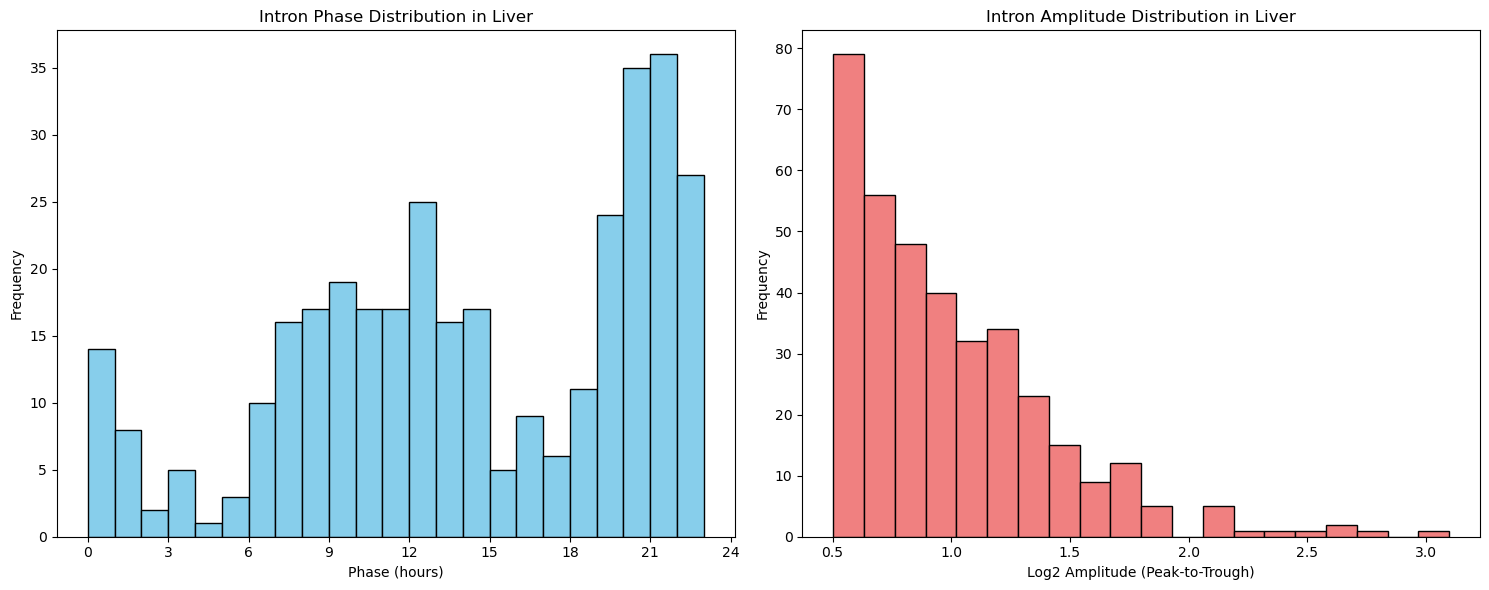

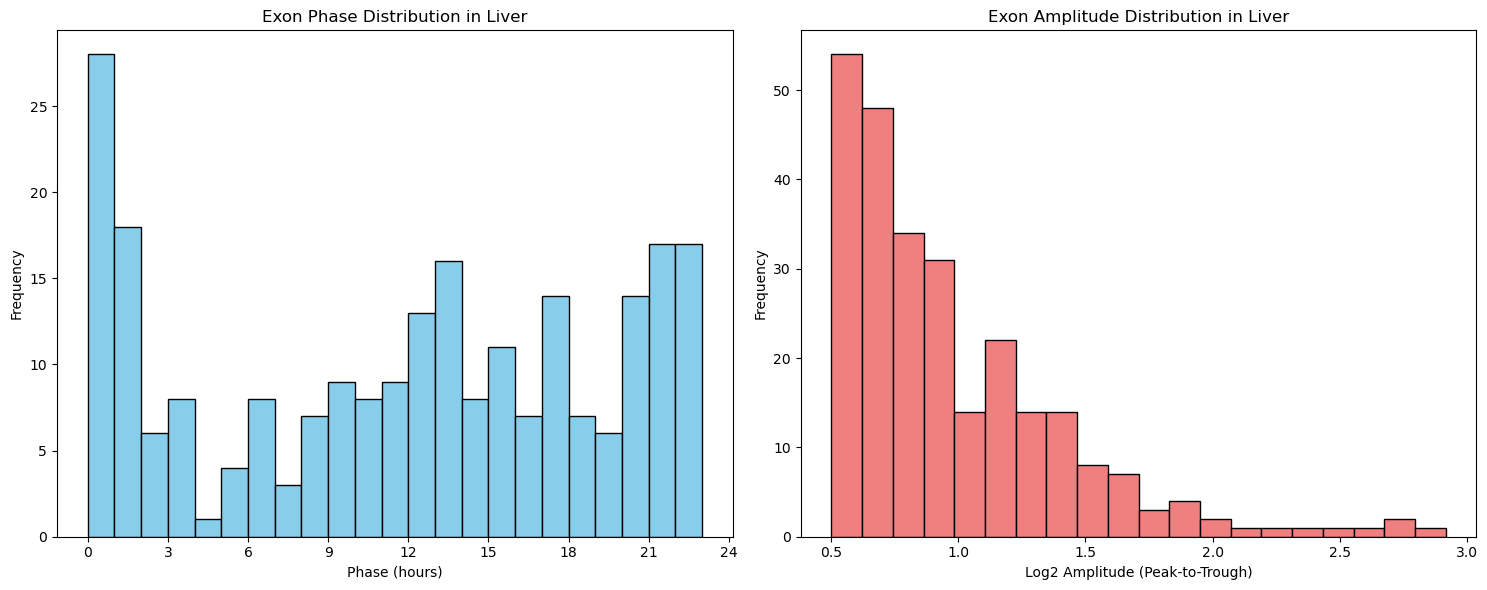

In [21]:
def plot_phase_amplitude(results, tissue, feature):
    """
    Plot histograms of the phase and amplitudes of rhythmic genes.
    
    Parameters:
    results (DataFrame): Harmonic regression results containing 'phase' and 'amp'.
    tissue (str): Name of the tissue (e.g., 'liver', 'muscle').
    feature (str): Type of feature (e.g., 'intron', 'exon').
    """
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.hist(results['phase'], bins=np.arange(0, 24, 1), color='skyblue', edgecolor='black')
    plt.title(f'{feature.capitalize()} Phase Distribution in {tissue.capitalize()}')
    plt.xlabel('Phase (hours)')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(0, 25, 3))

    plt.subplot(1, 2, 2)
    plt.hist(np.log2(results['amp']), bins=20, color='lightcoral', edgecolor='black')
    plt.title(f'{feature.capitalize()} Amplitude Distribution in {tissue.capitalize()}')
    plt.xlabel('Log2 Amplitude (Peak-to-Trough)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_phase_amplitude(rhythmic_genes_liver_i, 'liver', 'intron')
plot_phase_amplitude(rhythmic_genes_liver_e, 'liver', 'exon')

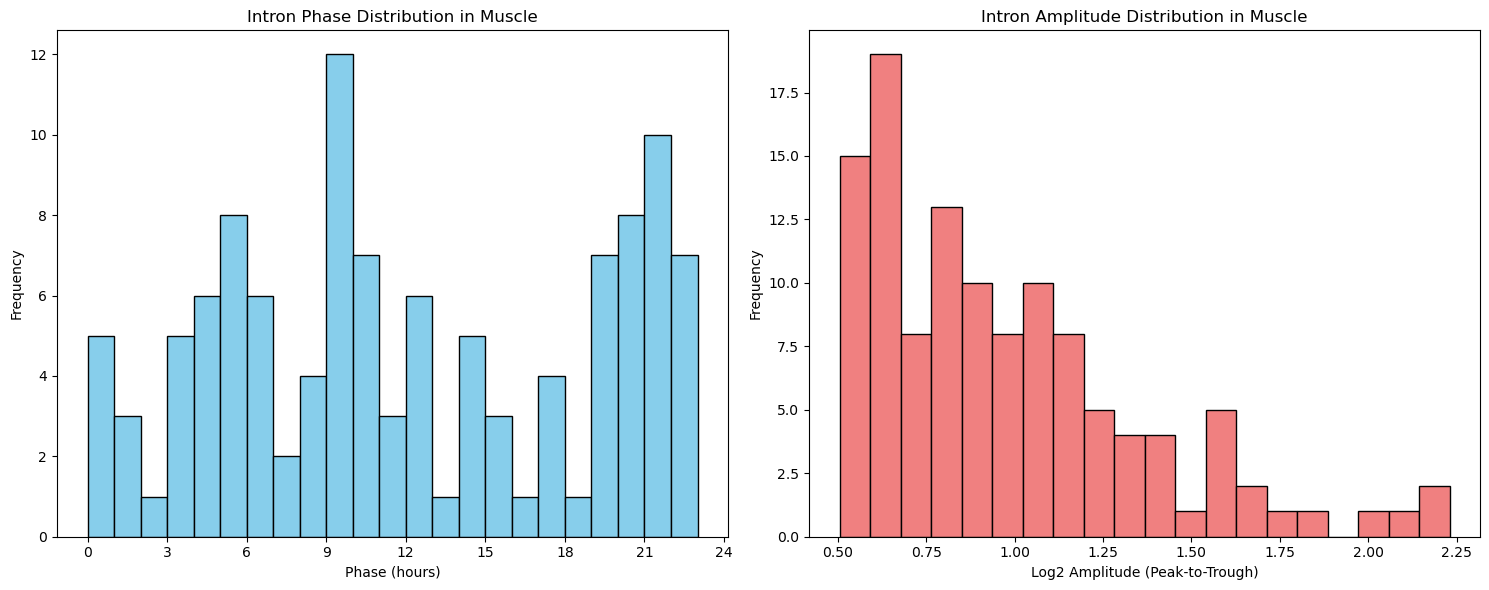

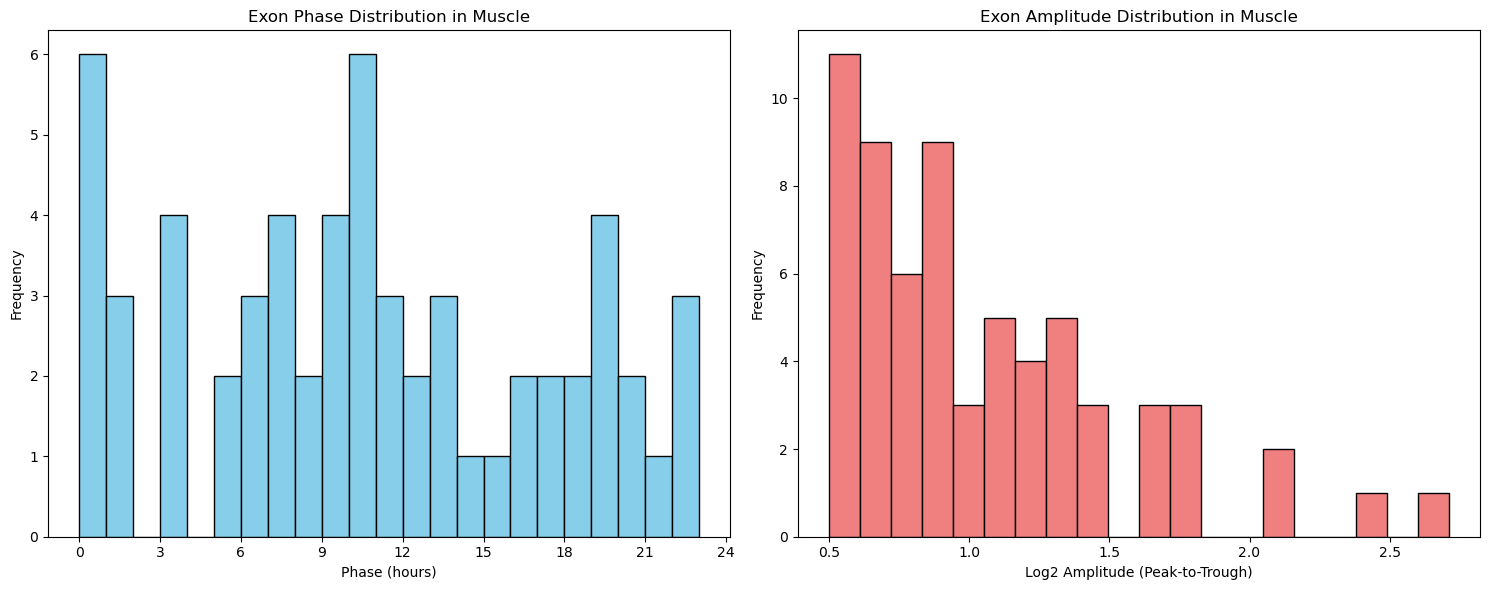

In [22]:
plot_phase_amplitude(rhythmic_genes_muscle_i, 'muscle', 'intron')
plot_phase_amplitude(rhythmic_genes_muscle_e, 'muscle', 'exon')

1. **Morning and Evening Waves**:
   - The phase distributions in both liver and muscle tissues show peaks at specific time intervals, corresponding to the 'morning' and 'evening' waves of gene expression. 
   - The peaks in the phase histograms align with circadian rhythms where genes are activated during the early (morning) and late (evening) parts of the 24-hour cycle.

2. **Liver vs. Muscle Comparisons**:
   - **Intron Data**:
     - In the liver, the 'morning' wave is pronounced with a cluster of genes peaking around early hours. The evening wave is slightly more diffuse but present.
     - In the muscle, there is less clustering of phases compared to the liver, suggesting more uniform rhythmicity or distributed waves across the day.
   - **Exon Data**:
     - Similar patterns are seen for exons in the liver, with distinct morning and evening peaks. The amplitudes also suggest a higher magnitude of transcriptional activity.
     - In muscle, exon phases are more evenly spread, with subtle clustering that may indicate weaker rhythmicity compared to the liver.

3. **Amplitude Distributions**:
   - Liver tissues generally show higher log2 amplitude distributions compared to muscle tissues, suggesting more pronounced transcriptional peaks in rhythmic genes. 
   - Muscle tissues exhibit a wider spread in amplitudes, indicating more variability in gene expression levels.

**Conclusion**:

The liver demonstrates a stronger and more distinct pattern of morning and evening waves of gene expression for both introns and exons. In contrast, the muscle tissue exhibits weaker and more distributed rhythms, with less clear phase clustering. These differences highlight tissue-specific regulation of circadian gene expression, with the liver showing a more robust circadian rhythm.

### Question 2

1. Related to Exercise 1, study the relationship between the peak times (i.e., phase) of pre-mRNA and mRNA for genes that exhibit rhythmic behavior at both the pre-mRNA and mRNA levels in each tissue independently. Use appropriate cutoffs in your analysis to select a subset of genes that are rhythmic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis.  
   **Hint:** Show a scatter plot of mRNA vs. pre-mRNA peak times. Explain your findings.

2. Show representative profiles of genes with short or long delays between the pre-mRNA and mRNA peak times.

3. From the delay between the pre-mRNA and mRNA ($\delta t$ [hr]), infer the mRNA half-life ($\tau$ [hr]) using the formula derived in the course:  


   $$\tan\left(\frac{2\pi \cdot \delta t}{24}\right) = \frac{24}{2\pi}  \frac{ \tau}{\ln(2)}$$
 

   Plot the histogram of the inferred mRNA half-lives for each tissue. Explain your findings.

4. For the selected genes that are common between muscle and liver, compare their mRNA half-lives. Show representative profiles of genes with tissue-specific half-lives. 

5. **(Bonus):** What can you infer about the splicing rate?  





#### Plot pre-mRNA, mRNA delay

Common rhythmic genes in liver = 380
Common rhythmic genes in muscle = 78


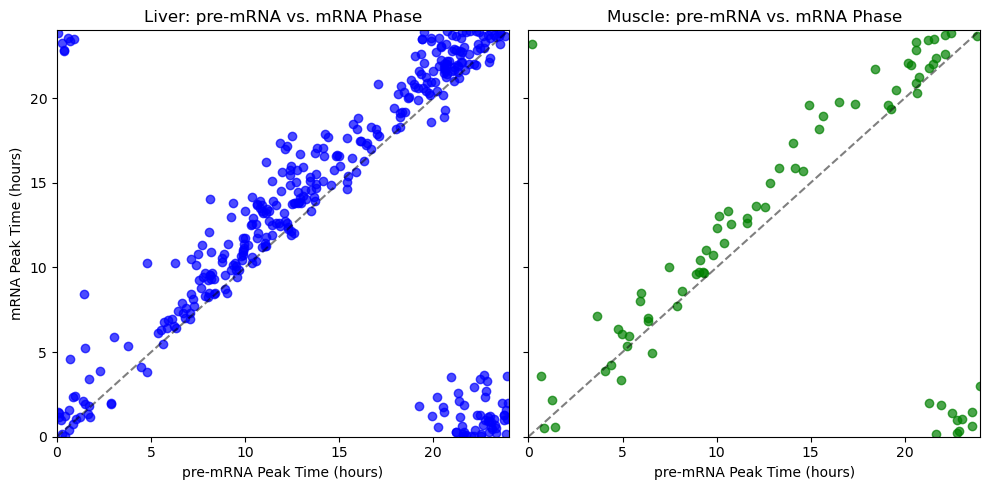

In [23]:
# Subset rhythmic genes with significant rhythmicity at both pre-mRNA and mRNA levels

q_val_threshold = 0.05
log2_amp_threshold = 0.1

rhythmic_genes_liver_i = results_intron_liver[np.logical_and(
    results_intron_liver['q_val'] < q_val_threshold,
    np.log2(results_intron_liver['amp']) > log2_amp_threshold
)]
rhythmic_genes_liver_e = results_exon_liver[np.logical_and(
    results_exon_liver['q_val'] < q_val_threshold,
    np.log2(results_exon_liver['amp']) > log2_amp_threshold
)]
rhythmic_genes_muscle_i = results_intron_muscle[np.logical_and(
    results_intron_muscle['q_val'] < q_val_threshold,
    np.log2(results_intron_muscle['amp']) > log2_amp_threshold
)]
rhythmic_genes_muscle_e = results_exon_muscle[np.logical_and(
    results_exon_muscle['q_val'] < q_val_threshold,
    np.log2(results_exon_muscle['amp']) > log2_amp_threshold
)]


# Find common rhythmic genes for liver and muscle
common_genes_liver = rhythmic_genes_liver_i.index.intersection(rhythmic_genes_liver_e.index)
common_genes_muscle = rhythmic_genes_muscle_i.index.intersection(rhythmic_genes_muscle_e.index)

print(f"Common rhythmic genes in liver = {len(common_genes_liver)}")
print(f"Common rhythmic genes in muscle = {len(common_genes_muscle)}")

phase_liver = pd.DataFrame({
    "pre-mRNA": rhythmic_genes_liver_i.loc[common_genes_liver, "phase"],
    "mRNA": rhythmic_genes_liver_e.loc[common_genes_liver, "phase"]
})

phase_muscle = pd.DataFrame({
    "pre-mRNA": rhythmic_genes_muscle_i.loc[common_genes_muscle, "phase"],
    "mRNA": rhythmic_genes_muscle_e.loc[common_genes_muscle, "phase"]
})

# Scatter plots for liver and muscle
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Liver plot
axes[0].scatter(phase_liver["pre-mRNA"], phase_liver["mRNA"], alpha=0.7, color="blue")
axes[0].plot([0, 24], [0, 24], 'k--', alpha=0.5)  # Line of equality
axes[0].set_title("Liver: pre-mRNA vs. mRNA Phase")
axes[0].set_xlabel("pre-mRNA Peak Time (hours)")
axes[0].set_ylabel("mRNA Peak Time (hours)")
axes[0].set_xlim(0, 24)
axes[0].set_ylim(0, 24)

# Muscle plot
axes[1].scatter(phase_muscle["pre-mRNA"], phase_muscle["mRNA"], alpha=0.7, color="green")
axes[1].plot([0, 24], [0, 24], 'k--', alpha=0.5)  # Line of equality
axes[1].set_title("Muscle: pre-mRNA vs. mRNA Phase")
axes[1].set_xlabel("pre-mRNA Peak Time (hours)")
axes[1].set_xlim(0, 24)
axes[1].set_ylim(0, 24)

plt.tight_layout()
plt.show()

We can see how majority of rhythmitic genes peak at the same hours in both liver and muscle, but that there are clear outliers

### Plot representative genes with short or long-delay

First we will create a function  `plot_gene_expression_one_tissue` (modifying the given `plot_gene_expression()`) in order to show intron and exon levels during the time series for a unique tissue. 

In [30]:
def plot_gene_expression_one_tissue(dat_melted, gene_name, tissue):
    """
    Plots the expression of a gene selected tissue.

    Parameters:
    dat_melted (pd.DataFrame): The melted gene expression dataset.
    gene_name (str): The gene to plot.
    tissue (str): Tissue of interest

    Returns:
    None
    """

    # Filter the melted DataFrame for the gene of interest
    data = dat_melted[dat_melted['gene.symb'] == gene_name]

    plt.figure(figsize=(10, 6))

    # Scatter plot
    sns.scatterplot(
        data=data[data['condition'] == tissue], 
        x='time', y='expression', hue='feature', style='feature',
        alpha=0.6, legend='full'
    )

    # Line plot
    sns.lineplot(
        data=data[data['condition'] == tissue],
        x='time', y='expression', hue='feature', estimator='mean',
        errorbar=None, legend=False
    )

    # Plot customization
    plt.title(f"{gene_name} Expression in {tissue}")
    plt.xlabel("Time (hours)")
    plt.ylabel("Expression Level")
    plt.grid(alpha=0.3)
    plt.legend(title="Condition", loc="upper right")
    plt.tight_layout()

    plt.show()

Now we compute this delay between exonic and intronic RNA for all the dataset and start selecting genes with characteristic values:

* Shortest delay between pre-RNA and RNA:

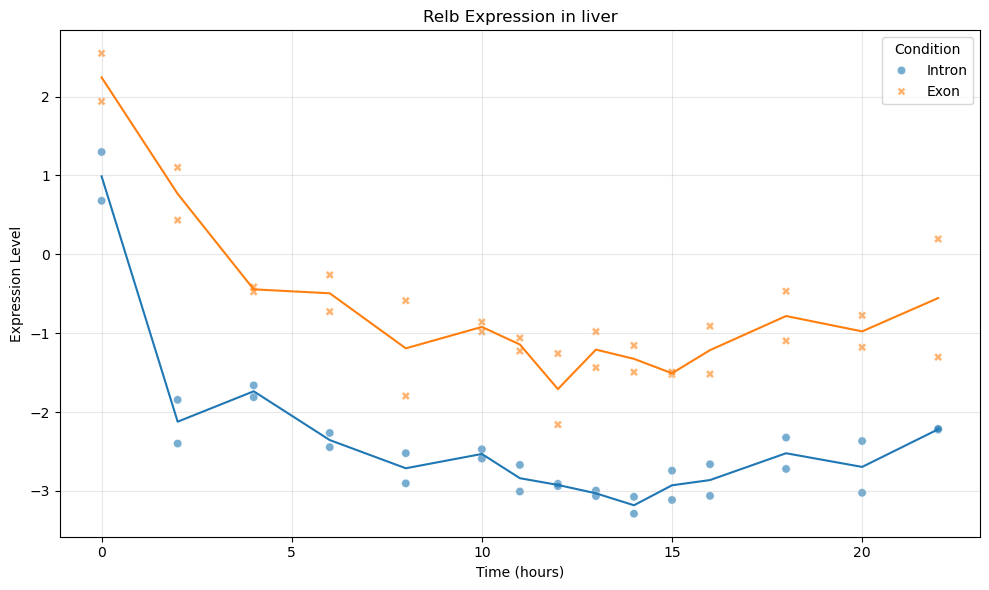

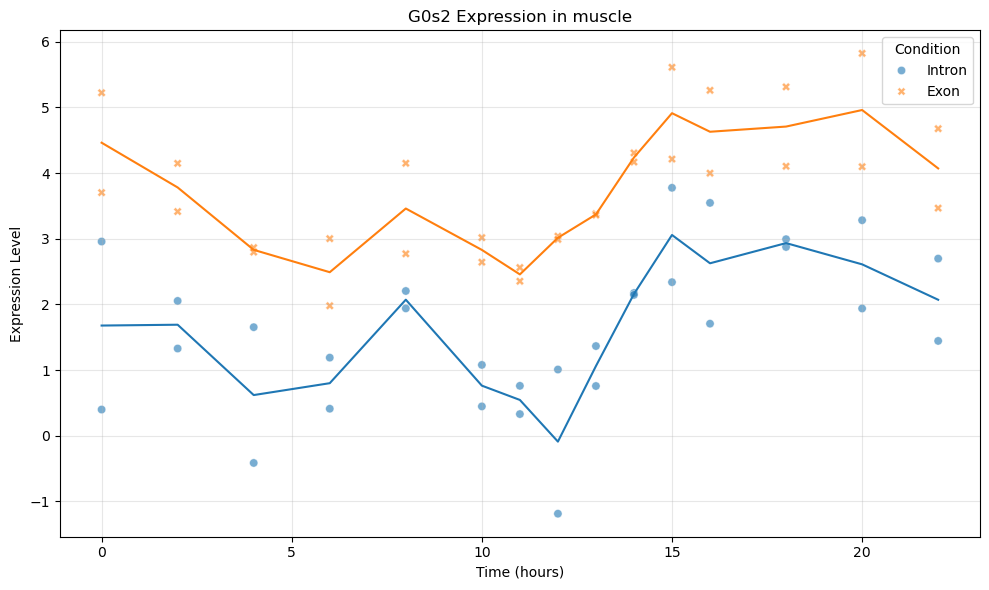

In [32]:
# Compute delay between intron and exon for liver and muscle
phase_difference_liver = rhythmic_genes_liver_e.loc[common_genes_liver, 'phase'] - rhythmic_genes_liver_i.loc[common_genes_liver, 'phase']
phase_difference_muscle = rhythmic_genes_muscle_e.loc[common_genes_muscle, 'phase'] - rhythmic_genes_muscle_i.loc[common_genes_muscle, 'phase']

# Restrict to genes with phase difference < 6 hours and exon later than intron
valid_genes_liver = phase_difference_liver[(phase_difference_liver > 0) & (phase_difference_liver < 6)].index
valid_genes_muscle = phase_difference_muscle[(phase_difference_muscle > 0) & (phase_difference_muscle < 6)].index

# Find gene with shortest delay in muscle and liver
shortest_delay_gene_liver = phase_difference_liver.loc[valid_genes_liver].idxmin()
shortest_delay_gene_muscle = phase_difference_muscle.loc[valid_genes_muscle].idxmin()

plot_gene_expression_one_tissue(dat_melted, shortest_delay_gene_liver, 'liver')
plot_gene_expression_one_tissue(dat_melted, shortest_delay_gene_muscle, 'muscle')

* Genes with delays of 3-4 hours between pre-RNA and RNA:

Number of genes in liver with delay between 3 and 4 hours: 29
Number of genes in muscle with delay between 3 and 4 hours: 5


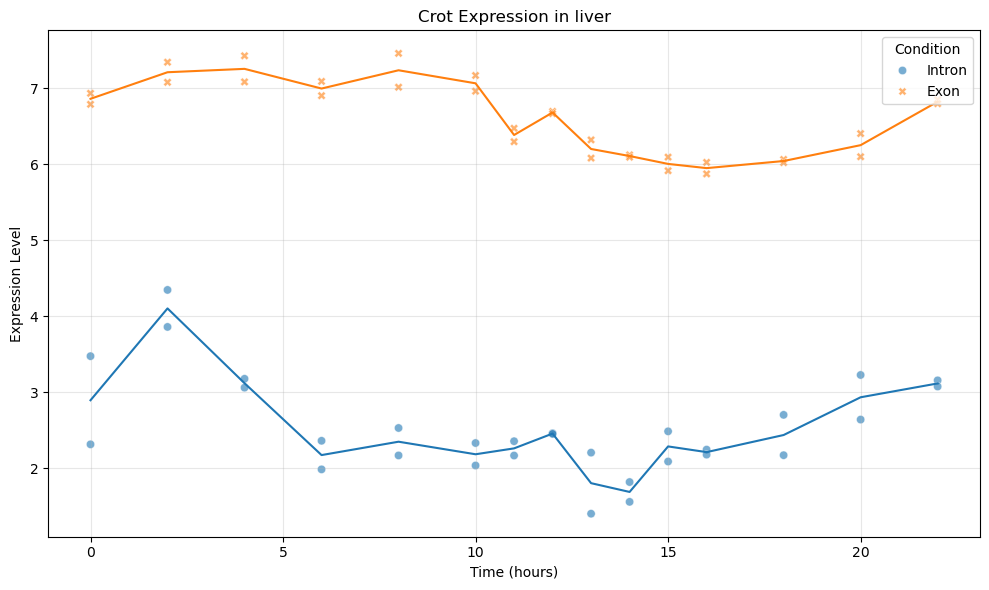

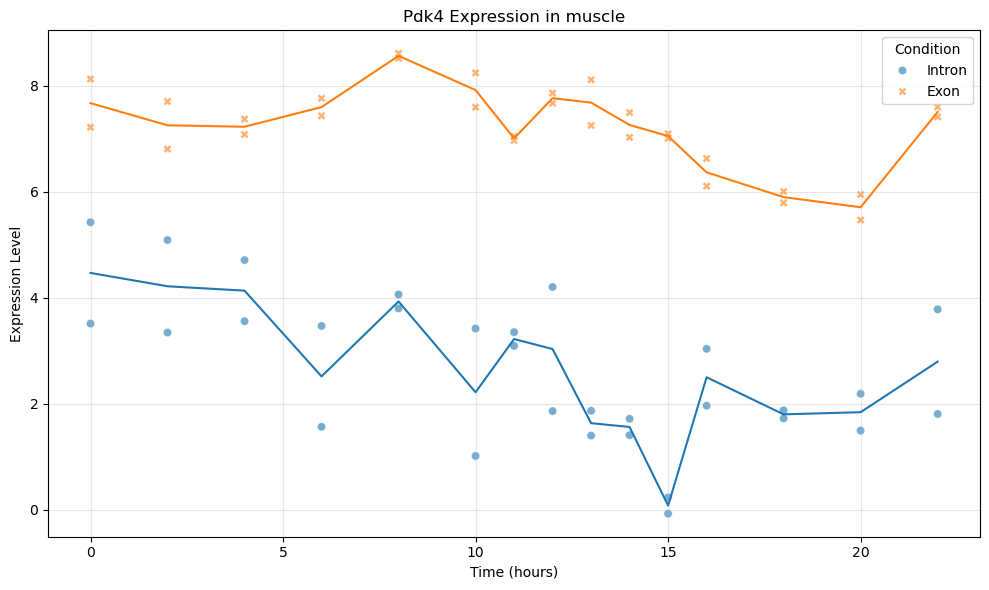

In [38]:
# Find gene with delay between 3 and 4 hours in muscle and liver

genes_delay_3_4_liver = phase_difference_liver[(phase_difference_liver > 3) & (phase_difference_liver < 4)].index
genes_delay_3_4_muscle = phase_difference_muscle[(phase_difference_muscle > 3) & (phase_difference_muscle < 4)].index

print(f'Number of genes in liver with delay between 3 and 4 hours: {len(genes_delay_3_4_liver)}')
print(f'Number of genes in muscle with delay between 3 and 4 hours: {len(genes_delay_3_4_muscle)}')

if len(genes_delay_3_4_liver) > 0:
    plot_gene_expression_one_tissue(dat_melted, genes_delay_3_4_liver[0], 'liver')
if len(genes_delay_3_4_muscle) > 0:
    plot_gene_expression_one_tissue(dat_melted, genes_delay_3_4_muscle[0], 'muscle')

### Compute half-life from the delay between intron and exon


Using the function give we create a function `compute_half_life()` that computes its value given a phase difference array of a gene:

In [35]:
def compute_half_life(delta_t, period=24):
    """
    Compute mRNA half-life based on the delay and derived formula.
    
    Parameters:
    delta_t: array-like, delays between intron and exon peak times in hours.
    period: float, circadian period, default is 24 hours.
    
    Returns:
    tau: array-like, inferred mRNA half-lives in hours.
    """
    return np.log(2)*(np.pi*2/period)*np.tan(2*np.pi*delta_t/period)


half_life_liver = compute_half_life(phase_difference_liver)
half_life_muscle = compute_half_life(phase_difference_muscle)

### Compare half-lives between muscle and liver

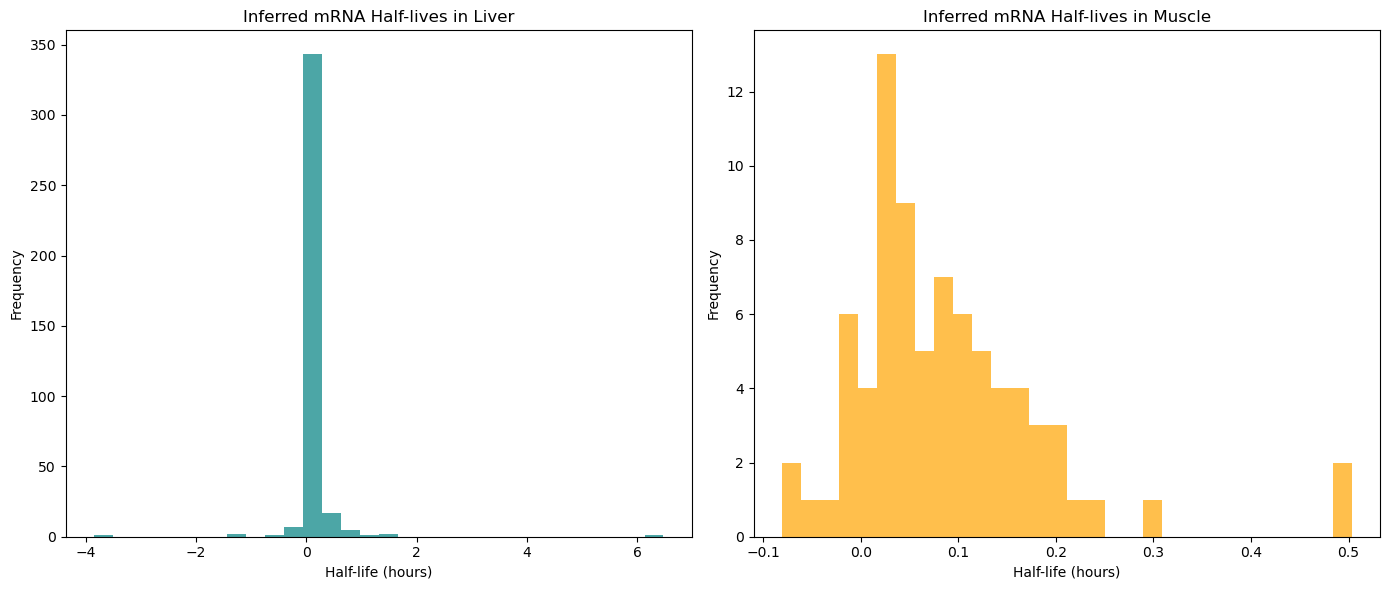

In [39]:
plt.figure(figsize=(14, 6))

# liver
plt.subplot(1, 2, 1)
plt.hist(half_life_liver, bins=30, color='teal', alpha=0.7)
plt.xlabel("Half-life (hours)")
plt.ylabel("Frequency")
plt.title("Inferred mRNA Half-lives in Liver")

# muscle
plt.subplot(1, 2, 2)
plt.hist(half_life_muscle, bins=30, color='orange', alpha=0.7)
plt.xlabel("Half-life (hours)")
plt.ylabel("Frequency")
plt.title("Inferred mRNA Half-lives in Muscle")

plt.tight_layout()
plt.show()

**Liver**
- **Observation**: The histogram shows a large spike at a half-life of 0, with no significant distribution across positive or negative half-life values.
- **Possible Causes**:
  1. **Phase Alignment Issue**: Many intron and exon peak times in liver might have nearly identical phases ($ \delta t \approx 0 $), resulting in trivial half-life calculations.
  2. **Thresholding Bias**: The chosen thresholds for rhythmic genes (e.g., q-value, $\log_2$-amplitude) might include genes with minimal rhythmic behavior, leading to ambiguous half-life results. This is due because when using the same thresholding for rhythmicity earlier on, the values were strict for muscle but not so much for liver. 
  3. **Mathematical Edge Case**: For very small $ \delta t $, the tangent function behaves nearly linearly, but computational noise or rounding errors could introduce inaccuracies.
- **Next Steps**:
  - Refine liver gene selection thresholds to exclude genes with trivial $\delta t $ or non-rhythmic behavior.
  - Examine whether the phase alignment between introns and exons is biologically meaningful or an artifact of the data.

**Muscle**

- **Observation**: The histogram displays a clear distribution of half-lives, primarily between $ 0.1-0.3$ hours, with a smaller cluster around $ 0.5 $ hours.
- **Interpretation**:
  1. Muscle tissue likely exhibits distinct delays between intron and exon peaks, resulting in varied half-life values.
  2. The majority of rhythmic genes in muscle have short half-lives ($<0.5 $ hours), suggesting rapid mRNA turnover in this tissue.
  3. A peak around $ 0.2-0.3 $ hours may indicate common regulatory mechanisms driving mRNA stability in muscle.
- **Comparison**: Unlike liver, muscle shows a biologically plausible range of half-lives, possibly due to clearer phase separation between intron and exon rhythmic genes.

**General Insights**
1. The stark contrast between liver and muscle data underscores tissue-specific differences in mRNA turnover mechanisms.
2. Muscle data reveals a realistic distribution of half-lives, suggesting prominent rhythmic regulatory processes in this tissue.
3. The liver data requires further refinement to derive meaningful half-life estimates.

### Plot representative genes with tissue-specific half-life

Finally, using the half-lifes values per gene computed earlier we can get those genes that behave very distinct between both tissues and check their profile expressions:

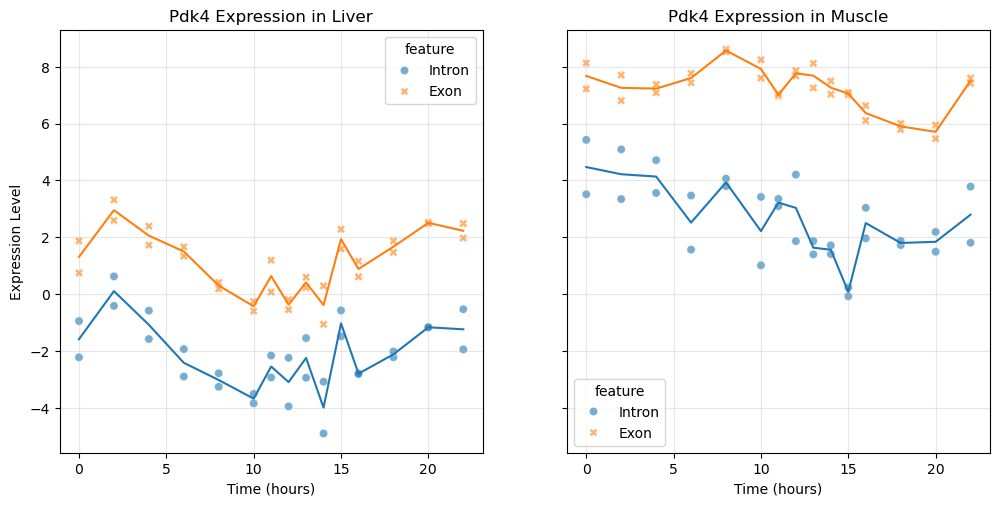

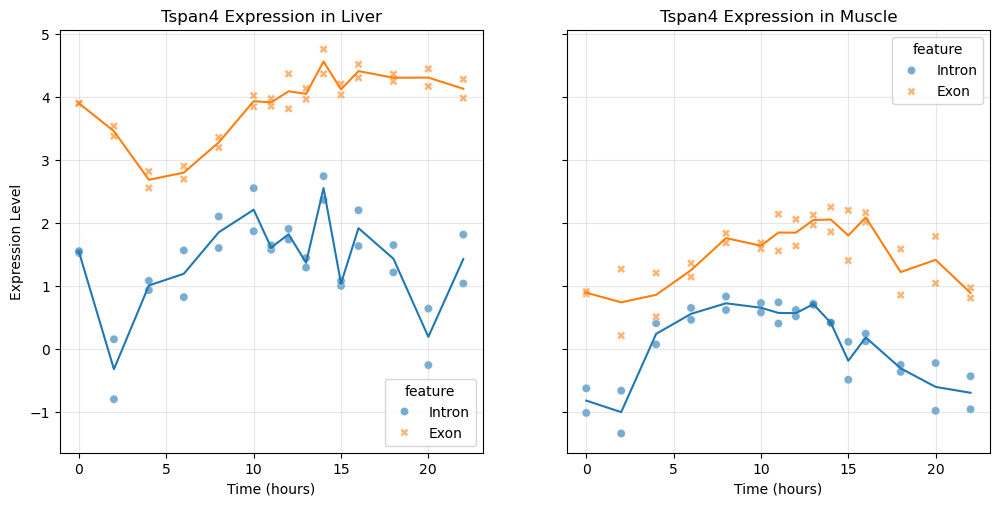

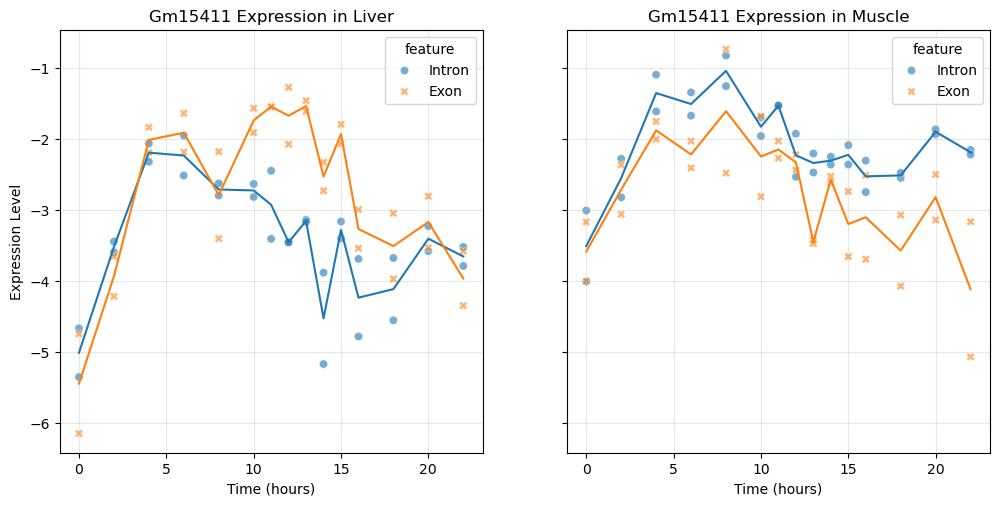

In [37]:
common_genes = common_genes_liver.intersection(common_genes_muscle)

half_life_liver_common = half_life_liver[common_genes]
half_life_muscle_common = half_life_muscle[common_genes]

# Identify genes with significant differences in half-lives between tissues

threshold_diff = 0.2  # Define a threshold for significant difference
tissue_specific_genes = half_life_liver_common[
    np.abs(half_life_liver_common - half_life_muscle_common) > threshold_diff
].index

# Select a few representative genes for tissue-specific analysis
representative_genes = tissue_specific_genes[:3]  # Selecting the first 3 genes as representatives

# Plot gene expression profiles for the representative genes
for gene in representative_genes:
    plot_gene_expression(dat_melted, gene)
 